In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt 
import numpy as np
import hemul
hemul.USE_FPGA=False
from hemul import heaan
from muxcnn.resnet_HEAAN import ResNetHEAAN
from muxcnn.utils import get_channel_last

from muxcnn.models.ResNet20 import ResNet, BasicBlock
from muxcnn.utils import load_params, load_img, decrypt_result
import struct

Using CPU version HEAAN
Using CPU version HEAAN
Using CPU version HEAAN


# 1. 원본 Pytorch 모델

In [3]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F

num_workers = 0
batch_size = 32
valid_size = 0.2

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=train_transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=test_transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified


- compare each layer's output
- Bad fit when alpha > 12?

In [4]:
# CIFAR-10 classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

model = ResNet(BasicBlock,[1,1,1])
model.eval() 

# Load trained parameters
load_params(model, fn_param="./ResNet8.pt",device='cpu')

In [21]:
from muxcnn.resnet_muxconv import ResNet_MuxConv

muxmodel = ResNet_MuxConv(model, alpha=14)

functions set
degrees = [7, 7, 15, 15, 27], margin = 0.01, eps = 0.02


In [24]:
valid_loader = torch.utils.data.DataLoader(test_data, batch_size=1, 
    sampler=None, num_workers=num_workers)

for img_tensor, label in valid_loader:    
    print(img_tensor.shape, label)
    result = muxmodel(img_tensor, debug=True)
    debug_info = muxmodel._debug_log
    print(result)
    
    break

torch.Size([1, 3, 32, 32]) tensor([3])
[MultParConv] (hi,wi,ci,ki,ti,pi) =(32,32, 3, 1, 3,  8)
[MultParConv] (ho,wo,co,ko,to,po) =(32,32,16, 1,16,  2)
[MultParConv] q = 2
2.3874 s
degree = 7
min, max -0.6125703509544014 0.6588413181368161
degree = 7
min, max -1.194131933087873 1.1941330925990232
degree = 15
min, max -1.1785111535321642 1.1785111466937461
degree = 15
min, max -1.1224098171975778 1.1224097440271894
degree = 27
min, max -1.0000000002810192 1.0000000004272178
[MultParConv] (hi,wi,ci,ki,ti,pi) =(32,32,16, 1,16,  2)
[MultParConv] (ho,wo,co,ko,to,po) =(32,32,16, 1,16,  2)
[MultParConv] q = 8
9.0039 s
degree = 7
min, max -0.7737993258813269 0.6088410925354563
degree = 7
min, max -1.194133174958593 1.1941225449369914
degree = 15
min, max -1.1785106590375036 1.1785111493587235
degree = 15
min, max -1.1224099705876014 1.1224073366759697
degree = 27
min, max -1.0000000004001262 1.0000000004699783
[MultParConv] (hi,wi,ci,ki,ti,pi) =(32,32,16, 1,16,  2)
[MultParConv] (ho,wo,co,ko,to

In [27]:
np.argmax(result[:10])

7

In [25]:
label

tensor([3])

Non-FHE Version already seems to be WRONG! 

Likely for the same reason, ReLU approximation error.
Fix it in this version first

In [23]:
for ll in debug_info:
    print(ll[0], ll[1][:10])

forward_early [1.12238944 1.63927188 1.55351724 1.55390433 1.70617009 1.76226107
 1.64370447 1.71671222 1.74105677 1.7084376 ]
basic0 [2.14905277 3.06722254 3.54111134 3.12994998 3.52839563 3.76825184
 3.0705478  3.8774067  3.24791308 3.6480522 ]
basic1 [-1.10434206e-10  6.80353096e-02 -5.28097437e-11  3.05748539e-01
  1.56191796e-10  1.15490176e+00 -6.29298435e-12  1.68407361e+00
  9.14756016e-11  1.52881001e+00]
basic2 [ 8.11500200e-11  8.74411294e-11 -1.54851602e-10  8.99658278e-11
  1.31389074e-10  4.01415603e-11  5.28198867e-11  1.49477728e-10
  6.08829609e-11  8.23501374e-01]
AVGPool [0.16420888 0.54411059 0.97069103 0.87823352 0.98644272 0.33636491
 1.10909532 0.56453414 1.02233353 0.82363945]


## FHE Setup

In [5]:
logp = 40
logq = 800
logn = 15

# Rotation 미리 준비 
rot_l = [2**i for i in range(15)]
rot_l = rot_l + [2**15-1, 
                 2**15-33, 2**15-32, 2**15-31,
                 2**15-17, 2**15-16, 2**15-15, 
                 2**15-9,2**15-8, 2**15-7] + [3,5,7,9,15,17, 31, 33]

hec = heaan.HEAANContext(logn, logp, logq, load_keys=True, rot_l=rot_l)

Initializing the scheme as the data owner
Loading a secret key from:  ./SecretKey.txt
loading secret key done.
HEAAN CKKS setup is ready 


In [7]:
fhemodel = ResNetHEAAN(model, hec, alpha=16, xmin=-80, xmax=80, min_depth=True)

function approximators set
degrees = [15, 15, 15, 15, 27], margin = 0.0005, eps = 0.01


### Pack and Encrypt the tensor image

In [ ]:
for img_tensor, label in valid_loader:    
    print(img_tensor.shape, label)
    for i in range(32):
        ctxt = fhemodel.pack_img_ctxt(img_tensor[i:i+1,:,:,:])
        result = fhemodel(ctxt)

        class_num = decrypt_result(hec, result)
        print("[FHE_CNN] Inference result:", class_num)
        print(f"[FHE_CNN] It's a {classes[class_num]}, ANSWER:", label[i])
        
        del ctxt

torch.Size([32, 3, 32, 32]) tensor([2, 2, 2, 7, 8, 1, 1, 8, 2, 7, 2, 3, 1, 5, 1, 9, 6, 1, 8, 0, 8, 9, 3, 8,
        6, 3, 9, 7, 8, 4, 3, 1])
[FHE_CNN] Inference started...
[FHE_CNN_EARLY] ConvBN started...
[MultParConv] Layer structure: (hi,wi,ci,ki,ti,pi) =(32,32, 3, 1, 3,  8)
ct_d 40 720
[FHE_CNN_EARLY] ConvBN finished in 25.67 sec
[FHE_CNN_EARLY] ReLU started...
APPR 15 40 720
[-0.71731493 -0.20030718  0.3593875  ... -0.67000985 -0.67000985
 -0.45448394]
min max -6.5997272566046234 8.248357129506793
APPR 15 40 520
[-0.09279812 -0.02594146  0.04653427 ... -0.08669126 -0.08669126
 -0.05883721]
min max -0.774310193459385 0.915605557349621
APPR 15 40 320
[-0.74670286 -0.22685884  0.40061635 ... -0.70561557 -0.70561536
 -0.49968856]
min max -1.1777810659994365 1.1777816071139817
APPR 15 40 120
[-0.98552142 -1.18351294  0.91484906 ... -1.0362515  -1.03625171
 -0.93369099]
min max -1.1836926450942704 1.1836924408883467
bootstrap done
AFTER bootstrap 40 800
APPR 27 40 600
[-1.03732695 -0.99

ct_d 40 80
[FHE_CNN BasicBlock] ConvBN2 finished in 95.50 sec


 ddddddd
[-0.32695432  1.43273672 -1.73167034 ... -4.08846971 -0.03746072
 -1.04959604]
[FHE_CNN BasicBlock] ConvBN_shortcut started...
[MultParConv] Layer structure: (hi,wi,ci,ki,ti,pi) =(32,32,16, 1,16,  2)
ct_d 40 200
[FHE_CNN BasicBlock] ConvBN_shortcut finished in 86.46 sec
[forward_bb] Shortcut <class.Ciphertext logp: 40 logq: 200 n: 32768>
ctxt <class.Ciphertext logp: 40 logq: 80 n: 32768>
<class.Ciphertext logp: 40 logq: 80 n: 32768> <class.Ciphertext logp: 40 logq: 80 n: 32768>
[-0.32695432  1.43273672 -1.73167034 ... -4.08846971 -0.03746072
 -1.04959604]
[-1.61392591  2.35783496 -0.81662397 ...  3.28412679  2.26527686
  2.13223482]
[FHE_CNN BasicBlock] ReLU2 started...
bootstrap done
APPR 15 40 800
[-1.94088023  3.79057168 -2.54829431 ... -0.80434291  2.22781614
  1.08263877]
min max -7.592985176945214 9.465628941853579
APPR 15 40 600
[-0.24923888  0.47517821 -0.32521766 ... -0.10402548  0.28530884
  0.13985029]


# 2. Cehck Ciphertext 

### 2.1. save Ciphertext to file

In [9]:
heaan.he.SerializationUtils.writeCiphertext(ctxt, "packed_img.dat")

### 2.2 Load using Python 

In [84]:
import struct

f = open("packed_img.dat", "rb")
encrypted_img = f.read()

data = struct.iter_unpack('l', encrypted_img[:8*3]) # Ctxt header
read_nslots, read_logp, read_logq = data

print("Ciphertext has the following FHE parameters:")
print("nslots, logp, logq  = ", read_nslots, read_logp, read_logq)

Ciphertext has the following FHE parameters:
nslots, logp, logq  =  (32768,) (40,) (800,)


### 2.3. Try to interpret encrypted data

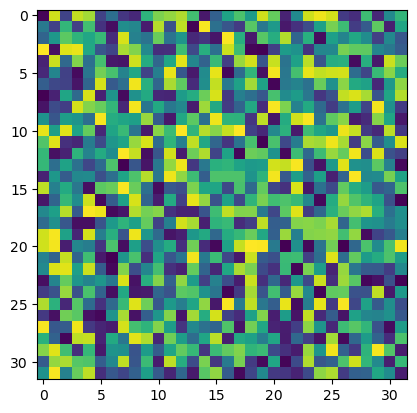

In [85]:
arr = np.frombuffer(encrypted_img[8*3:], dtype=np.int64)
reshaped = arr.reshape(32,32,-1)
plt.imshow(reshaped[:,:,0])

# 3. FHE model inference

In [ ]:
result = fhemodel(ctxt)

[FHE_CNN] Inference started...
[FHE_CNN_EARLY] ConvBN started...
[MultParConv] Layer structure: (hi,wi,ci,ki,ti,pi) =(32,32, 3, 1, 3,  8)
[FHE_CNN_EARLY] ConvBN finished in 33.48 sec
[FHE_CNN_EARLY] ReLU started...
bootstrap done
[FHE_CNN_EARLY] ReLU hinished in 61.43 sec
[FHE_CNN BasicBlock] ConvBN1 started...
[MultParConv] Layer structure: (hi,wi,ci,ki,ti,pi) =(32,32,16, 1,16,  2)
[FHE_CNN BasicBlock] ConvBN1 finished in 55.19 sec
[FHE_CNN BasicBlock] ReLU1 started...
bootstrap done
bootstrap done
[FHE_CNN BasicBlock] ReLU1 finished in 62.02 sec
[FHE_CNN BasicBlock] ConvBN2 started...
[MultParConv] Layer structure: (hi,wi,ci,ki,ti,pi) =(32,32,16, 1,16,  2)
[FHE_CNN BasicBlock] ConvBN2 finished in 55.97 sec
[FHE_CNN BasicBlock] ReLU2 started...
bootstrap done
bootstrap done
[FHE_CNN BasicBlock] ReLU2 finished in 61.26 sec
[FHE_CNN] First Basic Block finished in 234.51 sec

[FHE_CNN BasicBlock] ConvBN1 started...
[MultParConv] Layer structure: (hi,wi,ci,ki,ti,pi) =(32,32,16, 1,16,  2)


In [ ]:
class_num = decrypt_result(hec, result)
print("[FHE_CNN] Inference result:", class_num)
print(f"[FHE_CNN] It's a {classes[class_num]}")

### 3.1 Comparison with Pytorch result

In [ ]:
import torch
torch_result = model(img_tensor)
torch_class = torch.argmax(torch_result)
print(f"[PyTorch] It's a {classes[torch_class]}")